<a href="https://colab.research.google.com/github/michalwelna0/DeepLearningProjects/blob/main/PlanesClassificator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
### Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import os
import shutil
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.initializers import HeNormal


np.set_printoptions(precision=6, suppress=True)
print(tf.__version__)

2.3.0


In [2]:
  ### Loading Data
#!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
#!unzip -q flying-vehicles.zip

In [3]:
!rm -rf ./images

In [4]:
### How many images do we have in each type of plane
base_directory = './data/planes'
folder_names = ['drone', 'fighter-jet', 'helicopter','missile','passenger-plane','rocket']
raw_names_dict = {}
for plane in folder_names:
  raw_names_dict[plane] = len(os.listdir(os.path.join(base_directory, plane)))

print(raw_names_dict)

{'drone': 1332, 'fighter-jet': 1867, 'helicopter': 1387, 'missile': 1334, 'passenger-plane': 1424, 'rocket': 1186}


In [5]:
### Creating train/test/validation folders for each type of plane
data_directory = './images'

if not os.path.exists(data_directory):
  os.mkdir(data_directory)

train_directory = os.path.join(data_directory, 'train')
validation_directory = os.path.join(data_directory, 'validation')
test_directory = os.path.join(data_directory, 'test')

train_drone_dir = os.path.join(train_directory, 'drone')
train_jet_dir = os.path.join(train_directory, 'jet')
train_helicopter_dir = os.path.join(train_directory, 'helicopter')
train_missile_dir = os.path.join(train_directory, 'missile')
train_passenger_dir = os.path.join(train_directory, 'passenger')
train_rocket_dir = os.path.join(train_directory, 'rocket')

validation_drone_dir = os.path.join(validation_directory, 'drone')
validation_jet_dir = os.path.join(validation_directory, 'jet')
validation_helicopter_dir = os.path.join(validation_directory, 'helicopter')
validation_missile_dir = os.path.join(validation_directory, 'missile')
validation_passenger_dir = os.path.join(validation_directory, 'passenger')
validation_rocket_dir = os.path.join(validation_directory, 'rocket')

test_drone_dir = os.path.join(test_directory, 'drone')
test_jet_dir = os.path.join(test_directory, 'jet')
test_helicopter_dir = os.path.join(test_directory, 'helicopter')
test_missile_dir = os.path.join(test_directory, 'missile')
test_passenger_dir = os.path.join(test_directory, 'passenger')
test_rocket_dir = os.path.join(test_directory, 'rocket')

#make those directories if they do not exist
for dir in [train_directory, validation_directory, test_directory]:
  if not os.path.exists(dir):
    os.mkdir(dir)

dirs = [train_drone_dir,train_jet_dir,train_helicopter_dir, train_missile_dir, train_passenger_dir ,train_rocket_dir,
        validation_drone_dir, validation_jet_dir, validation_helicopter_dir, validation_missile_dir, validation_passenger_dir, validation_rocket_dir,
        test_drone_dir, test_jet_dir, test_helicopter_dir, test_missile_dir, test_passenger_dir, test_rocket_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)

In [6]:
drone_fnames = os.listdir(os.path.join(base_directory, 'drone'))
jet_fnames = os.listdir(os.path.join(base_directory, 'fighter-jet'))
helicopter_fnames = os.listdir(os.path.join(base_directory, 'helicopter'))
missile_fnames = os.listdir(os.path.join(base_directory, 'missile'))
passenger_fnames = os.listdir(os.path.join(base_directory, 'passenger-plane'))
rocket_fnames = os.listdir(os.path.join(base_directory, 'rocket'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]
jet_fnames = [fname for fname in jet_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]
helicopter_fnames = [fname for fname in helicopter_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]
missile_fnames = [fname for fname in missile_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]
rocket_fnames = [fname for fname in rocket_fnames if fname.split('.')[1].lower() in ['png', 'jpg', 'jpeg']]

fnames_list = [drone_fnames, jet_fnames, helicopter_fnames, missile_fnames, passenger_fnames, rocket_fnames] # list of all images for each type of plane

In [7]:
#Taking minimum size
lengths = []
for fname in fnames_list:
  lengths.append(len(fname))

size = min(lengths)
print(f'Full size of data_set included train/test/validation data : {size}')

Full size of data_set included train/test/validation data : 1173


In [8]:
# Splitting size on train/valid/test 
train_size = np.floor(size * 0.7).astype('int32')
validation_size = np.floor(size * 0.2).astype('int32')
test_size = (size - train_size - validation_size).astype('int32')

print(f'Train size: {train_size}')
print(f'Validation size: {validation_size}')
print(f'Test size: {test_size}')

train_range = train_size #821
validation_range = train_size + validation_size #1055
test_range = train_size + validation_size + test_size #1173 

Train size: 821
Validation size: 234
Test size: 118


In [9]:
train_dirs = [train_drone_dir,train_jet_dir,train_helicopter_dir, train_missile_dir, train_passenger_dir ,train_rocket_dir]
validation_dirs = [validation_drone_dir, validation_jet_dir, validation_helicopter_dir, validation_missile_dir, validation_passenger_dir, validation_rocket_dir]
test_dirs = [test_drone_dir, test_jet_dir, test_helicopter_dir, test_missile_dir, test_passenger_dir, test_rocket_dir]

def assing_plane_to_folder(fnames_list, folder_names, train_dirs, validation_dirs, test_dirs, train_range, validation_range, test_range) -> None:
  for idx_1, fnames_plane in enumerate(fnames_list):
    for idx_2, fname in enumerate(fnames_plane):
      if idx_2 <= train_range:
        src = os.path.join(base_directory, folder_names[idx_1], fname)
        dst = os.path.join(train_dirs[idx_1], fname)
        shutil.copyfile(src, dst) #copying file from data to images
      elif train_range < idx_2 <= validation_range:
        src = os.path.join(base_directory, folder_names[idx_1], fname)
        dst = os.path.join(validation_dirs[idx_1], fname)
        shutil.copyfile(src, dst) #copying file from data to images
      elif validation_range < idx_2 < test_range:
        src = os.path.join(base_directory, folder_names[idx_1], fname)
        dst = os.path.join(test_dirs[idx_1], fname)
        shutil.copyfile(src, dst) #copying file from data to images


assing_plane_to_folder(fnames_list, folder_names, train_dirs, validation_dirs, test_dirs, train_range, validation_range, test_range)

In [10]:
def print_folder_sizes(folder_names,train_dirs, validation_dirs, test_dirs) -> None:
  for train, valid, test, name in zip(train_dirs, validation_dirs, test_dirs, folder_names):
    print(f'{name} train set: {len(os.listdir(train))}, {name} validation set: {len(os.listdir(valid))}, {name} test set: {len(os.listdir(test))}')
    print("\n\n")

print_folder_sizes(folder_names, train_dirs, validation_dirs, test_dirs)

drone train set: 822, drone validation set: 234, drone test set: 117



fighter-jet train set: 822, fighter-jet validation set: 234, fighter-jet test set: 117



helicopter train set: 822, helicopter validation set: 234, helicopter test set: 117



missile train set: 822, missile validation set: 234, missile test set: 117



passenger-plane train set: 822, passenger-plane validation set: 234, passenger-plane test set: 117



rocket train set: 822, rocket validation set: 234, rocket test set: 117





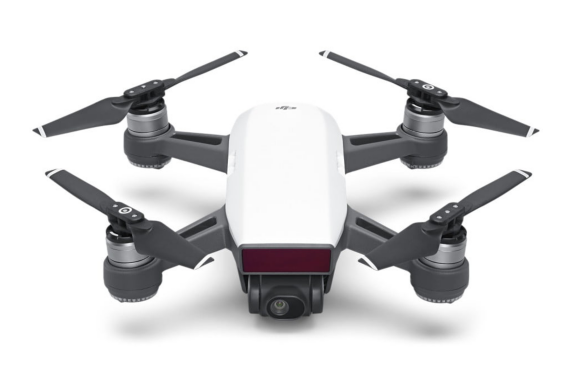

In [11]:
### Explore drone data
index = 316 #@param {type : 'slider', min:0, max:919}
dct_drone = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, dct_drone[index])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

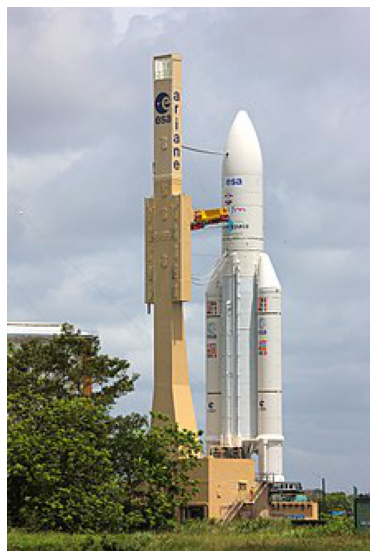

In [12]:
### Explore rocket data
index = 443 #@param {type : 'slider', min:0, max:919}
dct_rocket = dict(enumerate(rocket_fnames))
img_path = os.path.join(train_rocket_dir, dct_rocket[index])

img = image.load_img(img_path)
plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)
plt.show()

In [13]:
### Data preparing
train_datagen = ImageDataGenerator(rotation_range=35, width_shift_range=0.2, height_shift_range=0.2, rescale=1./255.,
                                 horizontal_flip = True, zoom_range = 0.1, shear_range = 0.1, fill_mode = 'nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_directory,
                                                    target_size = (150,150),
                                                    batch_size = 64,
                                                    class_mode = 'categorical')

validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                              target_size = (150,150),
                                                              batch_size = 64,
                                                              class_mode = 'categorical')

Found 4932 images belonging to 6 classes.
Found 1404 images belonging to 6 classes.


In [14]:
from tensorflow.keras.applications import VGG19
base = VGG19(input_shape = (150,150,3), include_top=False)
base.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [15]:
### Freeze some layer in VGG19 - 5 last only True
base.trainable = False
counter = -1
for layer in base.layers:
  counter  = counter + 1
  if counter >= 17:
    layer.trainable = True

In [16]:
### Build model
def build_model() -> None:
  model = Sequential()
  model.add(base)
  model.add(layers.Flatten())
  model.add(layers.Dense(1024, activation = "relu", kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4), kernel_initializer = HeNormal))
  model.add(layers.Dense(512, activation = "relu", kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4), kernel_initializer = HeNormal))
  model.add(layers.Dense(256, activation = "relu", kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4), kernel_initializer = HeNormal))
  model.add(layers.Dense(128, activation = "relu", kernel_regularizer = l1_l2(l1=1e-5, l2=1e-4), kernel_initializer = HeNormal))
  model.add(layers.Dense(6, activation = "softmax"))

  model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001),
                loss = "categorical_crossentropy",
                metrics = ["accuracy"])
  
  model.summary()
  return model

In [17]:
  model = build_model()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              8389632   
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 7

In [18]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [19]:
batch_size = 64
steps_per_epoch = train_size // batch_size
validation_steps = validation_size // batch_size
es = EarlyStopping(patience=10)


history = model.fit(train_generator, epochs=100, steps_per_epoch=steps_per_epoch,
                    validation_data = validation_generator,
                    validation_steps = validation_steps,
                    batch_size = batch_size,
                    callbacks = [tensorboard, es])

Epoch 1/100
 1/12 [=>............................] - ETA: 0s - loss: 3.6402 - accuracy: 0.2344WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
12/12 [==============================] - 23s 2s/step - loss: 3.4618 - accuracy: 0.2383 - val_loss: 3.3994 - val_accuracy: 0.3438
Epoch 2/100
12/12 [==============================] - 21s 2s/step - loss: 3.3516 - accuracy: 0.3291 - val_loss: 3.2885 - val_accuracy: 0.3125
Epoch 3/100
12/12 [==============================] - 21s 2s/step - loss: 3.2066 - accuracy: 0.3945 - val_loss: 3.0876 - val_accuracy: 0.4115
Epoch 4/100
12/12 [==============================] - 21s 2s/step - loss: 3.0973 - accuracy: 0.4167 - val_loss: 2.9552 - val_accuracy: 0.4844
Epoch 5/100
12/12 [==============================] - 24s 2s/step - loss: 3.0

In [21]:
def plot_metrics(history) -> None:
  df = pd.DataFrame(history.history)
  df['epochs'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x = df['epochs'], y = df['accuracy'], name = 'Accuracy', mode = 'markers+lines'))
  fig.add_trace(go.Scatter(x = df['epochs'], y = df['val_accuracy'], name = 'Val_Accuracy', mode = 'markers+lines'))
  fig.update_layout(width = 1000, height = 400, title = "Accuracy vs. Val_accuracy", xaxis_title = "Epochs", yaxis_title = "Accuracy")
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x = df['epochs'], y = df['loss'], name = 'Loss', mode = 'markers+lines'))
  fig.add_trace(go.Scatter(x = df['epochs'], y = df['val_loss'], name = 'Val_loss', mode = 'markers+lines'))
  fig.update_layout(width = 1000, height = 400, title = "Lossy vs. Val_Loss", xaxis_title = "Epochs", yaxis_title = "Loss")
  fig.show()

plot_metrics(history)

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size = (150,150),
                                                    batch_size = 1,
                                                    class_mode = 'categorical',
                                                    shuffle = False)

y_prob = model.predict(test_generator)

Found 702 images belonging to 6 classes.


In [24]:
y_prob

array([[0.998761, 0.000376, 0.000618, 0.000025, 0.000203, 0.000019],
       [0.437252, 0.017019, 0.201166, 0.13598 , 0.12156 , 0.087024],
       [0.910463, 0.009647, 0.033311, 0.002251, 0.027867, 0.016462],
       ...,
       [0.448175, 0.009854, 0.247889, 0.047532, 0.0485  , 0.198051],
       [0.016229, 0.0003  , 0.441943, 0.036733, 0.136472, 0.368323],
       [0.022334, 0.001062, 0.423816, 0.077965, 0.03988 , 0.434943]],
      dtype=float32)

In [25]:
y_pred = np.argmax(y_prob, axis = 1)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 1, 0, 0,
       5, 2, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0,
       0, 5, 3, 0, 0, 2, 2, 0, 0, 0, 4, 1, 0, 0, 3, 0, 2, 0, 0, 0, 4, 0,
       0, 0, 0, 5, 0, 0, 0, 4, 2, 4, 0, 0, 0, 0, 0, 3, 2, 0, 0, 4, 0, 0,
       2, 2, 1, 0, 0, 3, 2, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 2, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 3, 1, 1, 1, 1, 1, 0, 1, 1, 3, 5, 0, 1, 1,
       0, 0, 4, 5, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 3, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 0, 1, 1, 3,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 5, 0, 1, 0, 0, 4, 2, 2, 0, 4, 3,
       0, 4, 4, 2, 2, 0, 5, 5, 4, 1, 0, 0, 5, 3, 2, 2, 0, 5, 2, 3, 4, 5,
       4, 5, 5, 2, 1, 5, 5, 0, 5, 2, 4, 2, 5, 2, 0, 5, 5, 4, 5, 0, 0, 1,
       5, 0, 5, 5, 2, 3, 2, 0, 4, 2, 5, 3, 0, 2, 3,

In [26]:
y_test = test_generator.classes
y_test

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,

In [33]:
errors = pd.DataFrame({'y_test': y_test, 'y_pred' : y_pred}, index = test_generator.filenames)
errors.head()

,y_test,y_pred
drone/00000005.jpg,0,0
drone/00000051.png,0,0
drone/00000057.jpg,0,0
drone/00000092.jpg,0,0
drone/00000109.jpg,0,0


In [28]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[90,  3,  9,  4,  7,  4],
       [22, 81,  2,  7,  1,  4],
       [26,  3, 35,  8, 19, 26],
       [13,  4,  9, 40,  5, 46],
       [23,  4,  6, 10, 60, 14],
       [16,  1, 28,  3, 12, 57]])

In [30]:
def plot_confusion_matrix(conf_matrix) -> None:
  conf_matrix = conf_matrix[::-1] #last row becomes first row and vice versa
  classes = list(test_generator.class_indices.keys())
  df = pd.DataFrame(conf_matrix, columns=classes, index=classes[::-1])

  import plotly.figure_factory as ff
  fig = ff.create_annotated_heatmap(z = df.values, x=list(df.columns), y=list(df.index), colorscale = 'viridis', showscale=True, reversescale=True)
  fig.update_layout(title = "Confusion Matrix", width = 1000, height = 800)
  fig.show()

plot_confusion_matrix(conf_matrix)

In [44]:
errors['incorrect'] = (errors['y_test'] != errors['y_pred']) * 1
incorrect = errors[errors['incorrect'] == 1].index
#for incor in incorrect:
  #print(incor)

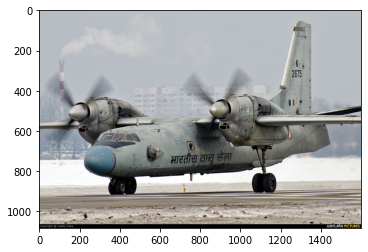

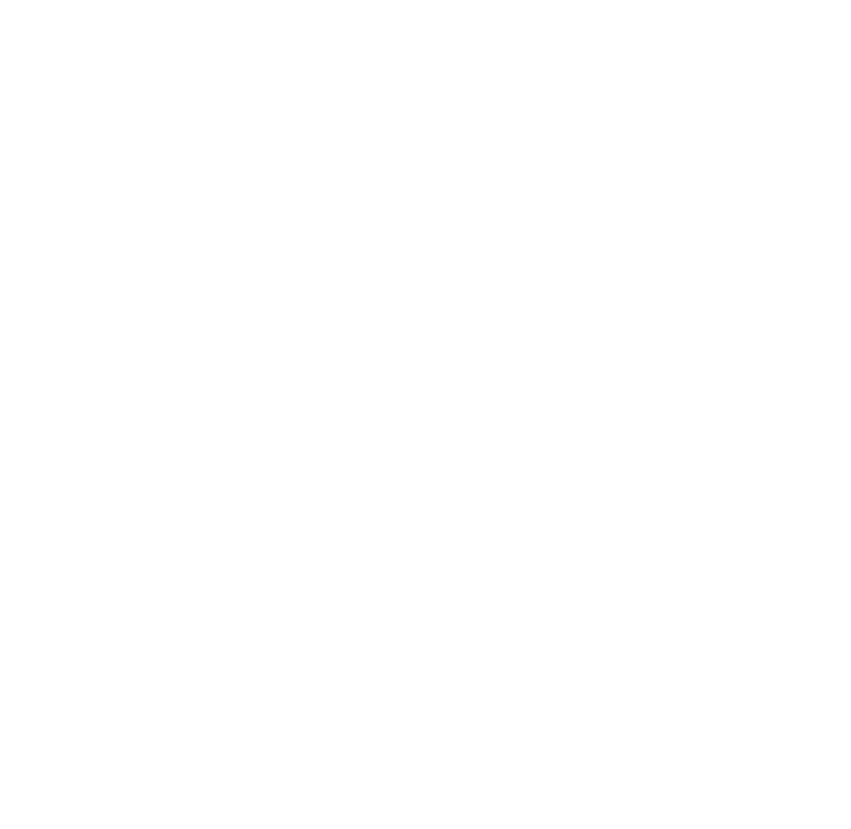

In [43]:
### Show rocket where our model was incorrect
img_path = os.path.join(test_rocket_dir, '00000958.jpg')

img = image.load_img(img_path)
plt.imshow(img)
plt.figure(figsize=(15,15))
plt.grid('off')
plt.axis('off')
plt.show()